# Week 10 exercises

## Exercise 12.1

In [7]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

import statsmodels.formula.api as smf

In [25]:
#functions provided by book for dataset
def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions
    
    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

def PlotFittedValues(model, results, label=''):
    """Plots original data and fitted values.

    model: StatsModel model object
    results: StatsModel results object
    """
    years = model.exog[:,1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model', color='#ff7f00')
    
def PlotLinearModel(daily, name):
    """Plots a linear fit to a sequence of prices, and the residuals.
    
    daily: DataFrame of daily prices
    name: string
    """
    model, results = RunLinearModel(daily)
    PlotFittedValues(model, results, label=name)
    thinkplot.Config(title='Fitted values',
                     xlabel='Years',
                     xlim=[-0.1, 3.8],
                     ylabel='Price per gram ($)')
    
def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')
    
def SimulateResults(daily, iters=101, func=RunLinearModel):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq
    
def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    
    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

#read in the data
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
dailies = GroupByQualityAndDay(transactions)

In [26]:
#New model 
def quadModel(daily):
    daily['years2'] = daily.years**2
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results

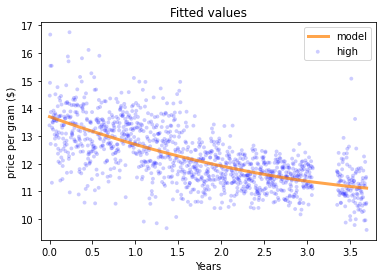

In [28]:
#code provided by book to get predictions
name = 'high'
daily = dailies[name]

model, results = quadModel(daily)
results.summary()    

PlotFittedValues(model, results, label=name)
thinkplot.Config(title='Fitted values',
                 xlabel='Years',
                 xlim=[-0.1, 3.8],
                 ylabel='price per gram ($)')


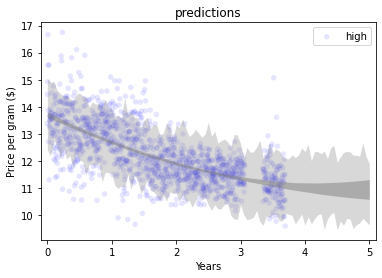

In [29]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=quadModel)
thinkplot.Config(title='predictions',
                 xlabel='Years',
                 xlim=[years[0]-0.1, years[-1]+0.1],
                 ylabel='Price per gram ($)')

## Exercise 12.2

In [34]:
#Code from the book
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [35]:
#class to test series correlation
class SerialCorrelationTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [36]:
#Testing correlation on consecutive prices
name = 'high'
daily = dailies[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.485229376194738 0.0


In [37]:
#test correlation in residuals
_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)    

0.07570473767506256 0.009


In [39]:
#test correlation in our quadratic model from Exercise 12.1
_, results = quadModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.05607308161289916 0.041
